TO DO

1. Make fits 
2. Find correlation plots
3. Make S map with varying delta

Importing the needed packages

In [8]:
from os import sep
import numpy as np
import matplotlib.pyplot as plt
# import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation

Writing the funtions needed

generate_RA_DEC_mesh generates RA and DEC mesh for the DATA which will be used for calculating the distances between different points.

Calc_l find the distance between two points on the space returns the value in arcsecond


In [9]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute


Importing the FITs file and some testing the data

In [10]:
########## importing and testing the file
FITS1 = '../FITS_file/OMC_BandE.fits'
hdul = fits.open(FITS1)
# print(hdul.info())
MapStokesI = hdul[0]
MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapPolAngle = hdul[11]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]


MapPolSNR = MapPolFlux.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()

######## taking points only with singal to noise ratio more than 2
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapPolFlux.data/MapPolFluxError.data
Selector = (MapPolSNR.data < 2)

BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan

############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()

Finding the value of angle dispersion function at the value 50,50 (pixel value)

1st step: selecting points that lie in the annular ring

2nd step: use this grid to select the polarization angles that lie in the annular ring

3rd step: find the difference between the polarization angle at (50,50) and the annular ring

4th step: square the difference and find rms value which will be the angle dispersion value

In [11]:

############## Testing the algorithm at point x_index,y_index

x_index = 50
y_index = 50
set_delta = 0.5
############## making the filter for selecting points withing the ring
seperation.data = Calc_l(RA_grid[x_index,y_index],DEC_grid[x_index,y_index],RA_grid,DEC_grid)
seperation_selector = (seperation.data<0.5*set_delta)
seperation.data[seperation_selector] = np.nan
seperation_selector = (seperation.data>1.5*set_delta)
seperation.data[seperation_selector] = np.nan


############## first version
AngleDiff = BlankedMapPolAngle.data - BlankedMapPolAngle.data[x_index,y_index]
Angle_selector =AngleDiff>90
AngleDiff[Angle_selector] = AngleDiff[Angle_selector] - 180
Angle_selector = AngleDiff<-90
AngleDiff[Angle_selector] = AngleDiff[Angle_selector] + 180
seperation_selector = (seperation.data >0)
S = np.nanmean(AngleDiff[seperation_selector]**2)**0.5
print(S)


############ second version
tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[x_index,y_index] - BlankedMapStokesQ.data[x_index,y_index]*BlankedMapStokesU.data
tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[x_index,y_index] + BlankedMapStokesU.data*BlankedMapStokesU.data[x_index,y_index]

AngleDiff_v2 = (180/np.pi)*0.5*np.arctan(tempa/tempb)
Angle_selector_v2 =AngleDiff_v2>90
AngleDiff_v2[Angle_selector_v2] = AngleDiff_v2[Angle_selector_v2] - 180
Angle_selector_v2 = AngleDiff_v2<-90
AngleDiff_v2[Angle_selector_v2] = AngleDiff_v2[Angle_selector_v2] + 180
S2 = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
print(S2)

11.882757785154032
11.882757785154032


Use this one method over all the sky map with a nested for loop

In [12]:

########## Running the algorithm on each cell
set_delta = 0.5   # in arcminute
S_map = BlankedMapPolAngle.copy()
S_map_v2 = BlankedMapPolAngle.copy()
for i in range(RA_grid.shape[0]):
    for j in range(RA_grid.shape[1]):

        ##### seperation filter
        seperation.data = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
        seperation_selector = (seperation.data<0.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data>1.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data >0)

        ##### first version
        AngleDiff = BlankedMapPolAngle.data - BlankedMapPolAngle.data[i,j]
        Angle_selector =AngleDiff>90
        AngleDiff[Angle_selector] = AngleDiff[Angle_selector] - 180
        Angle_selector = AngleDiff<-90
        AngleDiff[Angle_selector] = AngleDiff[Angle_selector] + 180
        S = np.nanmean(AngleDiff[seperation_selector]**2)**0.5
        S_map.data[i,j] = S

        ##### second version
        tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[i,j] - BlankedMapStokesQ.data[i,j]*BlankedMapStokesU.data
        tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[i,j] + BlankedMapStokesU.data*BlankedMapStokesU.data[i,j]
        AngleDiff_v2 = 0.5*np.arctan(tempa/tempb)
        Angle_selector_v2 =AngleDiff_v2>90
        AngleDiff_v2[Angle_selector_v2] = AngleDiff_v2[Angle_selector_v2] - 180
        Angle_selector_v2 = AngleDiff_v2<-90
        AngleDiff_v2[Angle_selector_v2] = AngleDiff_v2[Angle_selector_v2] + 180
        S_v2 = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
        S_map_v2.data[i,j] = S_v2




/tmp/ipykernel_8192/3245415240.py:22: RuntimeWarning: Mean of empty slice
  S = np.nanmean(AngleDiff[seperation_selector]**2)**0.5
/tmp/ipykernel_8192/3245415240.py:33: RuntimeWarning: Mean of empty slice
  S_v2 = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5


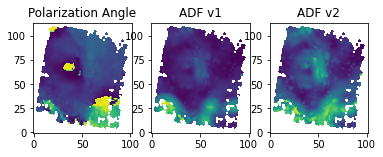

In [13]:
plt.figure()
ax3 = plt.subplot(131)
ax3.imshow(MapPolAngle.data,origin='lower')
ax1 = plt.subplot(132)
ax1.imshow(S_map.data,origin='lower')
ax2 = plt.subplot(133)
ax2.imshow(S_map_v2.data,origin='lower')
ax3.set_title('Polarization Angle')
ax1.set_title('ADF v1')
ax2.set_title('ADF v2')
plt.show()


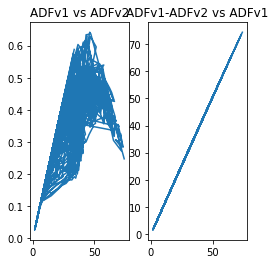

In [14]:
adf_v1 = S_map.data.flatten()
adf_v2 = S_map_v2.data.flatten()
plt.figure()


ax1 = plt.subplot(122)
ax1.plot(adf_v1,adf_v2)
ax2 = plt.subplot(123)
ax2.plot(adf_v1-adf_v2,adf_v1)
ax1.set_title('ADFv1 vs ADFv2')
ax2.set_title('ADFv1-ADFv2 vs ADFv1')
plt.show()

In [15]:

# s_map_array = S_map_v2.data.flatten()
# Pol_array = BlankedMapPol.data.flatten()

# y_min = np.nanmin(Pol_array)
# y_max = 20
  
# x_min = np.nanmin(s_map_array)
# x_max = np.nanmax(s_map_array)
  
# x_bins = np.arange(x_min, x_max, 0.01)
# y_bins = np.arange(y_min, y_max, 0.1)

# fig = plt.subplots(figsize =(10, 10))
# # Creating plot
# plt.hist2d(s_map_array,Pol_array,bins =[x_bins, y_bins])
# plt.title("P X S 2D histogram")
# plt.ylabel('P [%]')
# plt.xlabel('S [deg]')
# plt.show()

In [16]:
# def lin_fit(x, a, b):
#     return a + b*x

# s_map_array = S_map_v2.data.flatten()
# Pol_array = BlankedMapPol.data.flatten()

# log_s = np.log(s_map_array)
# log_p = np.log(Pol_array)

# y_min = np.nanmin(log_p)
# y_max = np.log(50)
  
# x_min = np.nanmin(log_s)
# x_max = np.nanmax(log_s)
  
# x_bins = np.arange(x_min, x_max, 0.075)
# y_bins = np.arange(y_min, y_max, 0.075)

# df = pd.DataFrame({'logp': log_p,'logs':log_s})
# df = df.dropna()
# param, param_cov = curve_fit(lin_fit, df['logs'], df['logp'])

# fit_func = lin_fit(x_bins,param[0],param[1])
# print(param[0],param[1])
# fig = plt.subplots(figsize =(10, 10))
# # Creating plot

# plt.hist2d(log_s,log_p,bins =[x_bins, y_bins])
# plt.plot(x_bins,fit_func,'r',linewidth=3)
# plt.title("log P X log S 2D histogram")
# plt.ylabel('log P ')
# plt.xlabel('log S ')
# plt.show()

In [17]:

# I_map_array = BlankedMapStokesI.data.flatten()

# y_min = np.nanmin(Pol_array)
# y_max = 20
  
# x_min = np.nanmin(I_map_array)
# x_max = np.nanmax(I_map_array)
  
# x_bins = np.arange(x_min, x_max, 1)
# y_bins = np.arange(y_min, y_max, 0.25)

# fig = plt.subplots(figsize =(10, 10))
# # Creating plot
# plt.hist2d(I_map_array,Pol_array,bins =[x_bins, y_bins])
# plt.title("P X I 2D histogram")
# plt.ylabel('P')
# plt.xlabel('I')
# plt.show()

In [18]:
# I_map_array = BlankedMapStokesI.data.flatten()
# Pol_array = BlankedMapPol.data.flatten()

# log_I = np.log(I_map_array)
# log_p = np.log(Pol_array)

# y_min = np.nanmin(log_p)
# y_max = np.log(50)
  
# x_min = np.nanmin(log_I)
# x_max = np.nanmax(log_I)
  
# x_bins = np.arange(x_min, x_max, 0.05)
# y_bins = np.arange(y_min, y_max, 0.05)

# df = pd.DataFrame({'logI': log_I,'logp':log_p})
# df = df.dropna()
# param, param_cov = curve_fit(lin_fit, df['logI'], df['logp'])

# fit_func = lin_fit(x_bins,param[0],param[1])
# print(param[0],param[1])

# fig = plt.subplots(figsize =(10, 10))
# # Creating plot
# plt.hist2d(log_I,log_p,bins =[x_bins, y_bins])
# plt.plot(x_bins,fit_func,'r',linewidth=3)
# plt.title("P X S 2D histogram")
# plt.ylabel('log p')
# plt.xlabel('log I')
# plt.show()